In [1]:
import Random#, logging
using  Plots, CSV, Gen#, Dates
using DataFrames: DataFrame
# Disable logging, because @animate is verbose otherwise
#Logging.disable_logging(Logging.Info);


(process:45860): GLib-GIO-WARNING **: 10:23:49.552: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.1900.3.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs


In [2]:
@gen function regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    n = length(xs)
    SubChunkSize = 40
    NumChunks = div(n, SubChunkSize, RoundUp)
    Indx = 1
    for i = 1:NumChunks
        slope = {(:slope, i)} ~ normal(0, 1000)
        intercept = {(:intercept, i)} ~ normal(0, 1000)
        noise = {(:noise, i)} ~ gamma(100, 100)
        prob_outlier = {(:prob_outlier, i)} ~ uniform(0, .6)
        # Next, we generate the actual y coordinates.
         ys = Float64[]
        for j = 1:40
            # Decide whether this point is an outlier, and set
            # mean and standard deviation accordingly
            if(!(Indx > n))
                if ({:data => Indx => :is_outlier} ~ bernoulli(prob_outlier))
                    (mu, std) = (0., 10000.)
                else
                    (mu, std) = (xs[Indx] * slope + intercept, noise)
                end
                # Sample a y value for this point
                push!(ys, {:data => Indx => :y} ~ normal(mu, std))
                Indx += 1
            end
        end
    end 
    ys
end;

In [3]:
using Plots
#length(floor(xs/40)+1)
function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    #print(xs)
    Dict(:slope => [trace[(:slope, i)] for i in 1:9],
         :intercept => [trace[(:intercept, i)] for i in 1:9],
         :inlier_std => [trace[(:noise, i)] for i in 1:9],
         :points => zip(xs, [trace[:data => i => :y] for i in 1:length(xs)]),
         :xs => xs,
         :outliers => [trace[:data => i => :is_outlier] for i in 1:length(xs)])
end

serialize_trace (generic function with 1 method)

In [26]:
function visualize_trace(trace::Trace; title="")
    trace = serialize_trace(trace)
    (MinX, MaxY) = minimum(trace[:points])
    (MaxX, MinY) = maximum(trace[:points])
    MaxY = -MinY
    outliers = [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if outlier]
    inliers =  [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if !outlier]
    Plots.scatter(map(first, inliers), map(last, inliers), markercolor="blue", label=nothing, title=title) 
    Plots.scatter!(map(first, outliers), map(last, outliers), markercolor="red", label=nothing)
    for i = 1:9
        inferred_line(x) = trace[:slope][i] * x + trace[:intercept][i]
        left_x = trace[:xs][40*(i-1)+1]
        left_y  = inferred_line(left_x)
        right_x = trace[:xs][40*i]
        right_y = inferred_line(right_x)
        Plots.plot!([left_x, right_x], [left_y, right_y], color = "black", size = 2, label = nothing)
    end
    Plots.plot!()
end
#, xlims=[MinX, MaxX], ylims=[MinY, MaxY]

visualize_trace (generic function with 1 method)

In [5]:
dataframe = CSV.read("../Data/Proccesed/DetrendedCov.csv", DataFrame)

,Column1,Date,N1,LoessN1,DetrendedN1
,Int64,Int64,Int64,Float64,Float64
1,1,0,63618,-3628.0,67246.0
2,2,4,11442,12206.4,-764.409
3,3,7,39145,24029.8,15115.2
4,4,10,28553,35819.2,-7266.18
5,5,9,16743,31895.1,-15152.1
6,6,8,30509,27971.0,2538.04
7,7,13,22794,47527.4,-24733.4
8,8,14,25014,51430.1,-26416.1
9,9,17,38687,63050.0,-24363.0


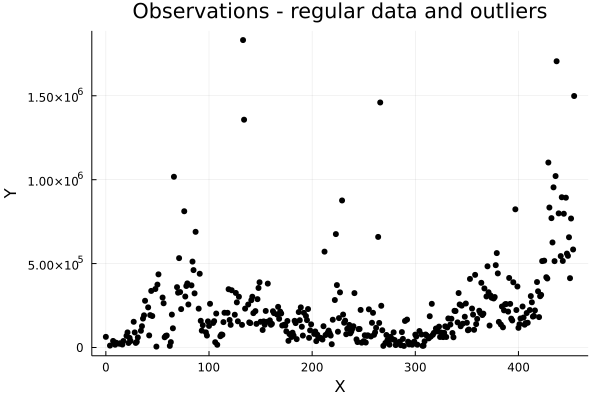

In [6]:
#using DataArrays
dataframe[!,:N1] = convert.(Base.Float64,dataframe[!,:N1])
dataframe[!,:Date] = convert.(Base.Float64,dataframe[!,:Date])

xs = dataframe."Date"[1:360]
ys = dataframe."N1"[1:360]

Plots.scatter(xs, ys, color="black", xlabel="X", ylabel="Y", 
              label=nothing, title="Observations - regular data and outliers")

In [7]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

In [8]:
observations = make_constraints(ys);

In [9]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

In [13]:
traces    = [first(Gen.importance_resampling(regression_with_outliers, (xs,), observations, 1000)) for i in 1:9]
#log_probs = [get_score(t) for t in traces]
#println("Average log probability: $(logmeanexp(log_probs))")
Plots.plot([visualize_trace(t) for t in traces]...)

In [35]:
Plots.plot([visualize_trace(t) for t in traces]...)
[visualize_trace(t) for t in traces]


UndefVarError: UndefVarError: Pkg not defined

In [12]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    # Block 1: Update the line's parameters
    line_params = select(:noise, :slope, :intercept)
    (tr, _) = mh(tr, line_params)
    
    # Blocks 2-N+1: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

In [ ]:
function block_resimulation_inference(xs, ys)
    observations = make_constraints(ys)
    (tr, W) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:100
        tr = block_resimulation_update(tr)
    end
    tr
end;

In [ ]:
scores = Vector{Float64}(undef, 3)
for i=1:3
    @time tr = block_resimulation_inference(xs, ys)
    scores[i] = get_score(tr)
end;
println("Log probability: ", logmeanexp(scores))

In [ ]:
scores = Vector{Float64}(undef, 3)
for i=1:3
    @time (tr, W) = importance_resampling(regression_with_outliers, (xs,), observations, 17000)
    scores[i] = get_score(tr)
end;
println("Log probability: ", logmeanexp(scores))

In [ ]:
t, = generate(regression_with_outliers, (xs,), observations)

viz = Plots.@animate for i in 1:200
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/200")
end;
gif(viz)

In [ ]:
@gen function line_proposal(current_trace)
    slope ~ normal(current_trace[:slope], 0.5)
    intercept ~ normal(current_trace[:intercept], 0.5)
end;

In [ ]:
function gaussian_drift_update(tr)
    # Gaussian drift on line params
    (tr, _) = mh(tr, line_proposal, ())
    
    # Block resimulation: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, Gen::select(:data => i => :is_outlier))
    end
    
    # Block resimulation: Update the prob_outlier parameter
    (tr, w) = mh(tr, Gen::select(:prob_outlier))
    (tr, w) = mh(tr, Gen::select(:noise))
    tr
end;

In [ ]:
tr1, = generate(regression_with_outliers, (xs,), observations)
tr2 = tr1

viz = Plots.@animate for i in 1:300
    global tr1, tr2
    tr1 = gaussian_drift_update(tr1)
    tr2 = block_resimulation_update(tr2)
    Plots.plot(visualize_trace(tr1; title="Drift Kernel (Iter $i)"), 
               visualize_trace(tr2; title="Resim Kernel (Iter $i)"))
end;
gif(viz)

In [ ]:
function gaussian_drift_inference(xs, observations)
    (tr, _) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:500
        tr = gaussian_drift_update(tr)
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = gaussian_drift_inference(xs, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

In [ ]:
import StatsBase

struct RANSACParams
    """the number of random subsets to try"""
    iters::Int

    """the number of points to use to construct a hypothesis"""
    subset_size::Int

    """the error threshold below which a datum is considered an inlier"""
    eps::Float64
    
    function RANSACParams(iters, subset_size, eps)
        if iters < 1
            error("iters < 1")
        end
        new(iters, subset_size, eps)
    end
end


function ransac(xs::Vector{Float64}, ys::Vector{Float64}, params::RANSACParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    for i=1:params.iters
        # select a random subset of points
        rand_ind = StatsBase.sample(1:length(xs), params.subset_size, replace=false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
        A = hcat(subset_xs, ones(length(subset_xs)))
        slope, intercept = A \ subset_ys # use backslash operator for least sq soln
        
        ypred = intercept .+ slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs.(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_num_inliers = num_inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept)
end;

using Pkg
Pkg.add("StatsBase")


In [ ]:
@gen function ransac_proposal(prev_trace, xs, ys)
    (slope_guess, intercept_guess) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope ~ normal(slope_guess, 0.1)
    intercept ~ normal(intercept_guess, 1.0)
end;

In [ ]:
function ransac_update(tr)
    # Use RANSAC to (potentially) jump to a better line
    # from wherever we are
    (tr, _) = mh(tr, ransac_proposal, (xs, ys))
    
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        (tr, _) = mh(tr, Gen::select(:prob_outlier))
        (tr, _) = mh(tr, Gen::select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, Gen::select(:data => i => :is_outlier))
        end
    end
    tr
end

In [ ]:
function ransac_inference(xs, ys, observations)
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope_intercept_init = choicemap()
    slope_intercept_init[:slope] = slope
    slope_intercept_init[:intercept] = intercept
    (tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))
    for iter=1:5
        tr = ransac_update(tr)
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = ransac_inference(xs, ys, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

In [ ]:
(slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))

viz = Plots.@animate for i in 1:100
    global tr

    if i % 20 == 0
        (tr, _) = mh(tr, ransac_proposal, (xs, ys))
    end

    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    (tr, _) = mh(tr, Gen::select(:prob_outlier))
    (tr, _) = mh(tr, select(:noise))
    (tr, _) = mh(tr, line_proposal, ())
    
    # Reclassify outliers
    for i=1:length(get_args(tr)[1])
        (tr, _) = mh(tr, Gen::(:data => i => :is_outlier))
    end

    visualize_trace(tr; title="Iteration $i")
end;Gen::

gif(viz)

In [ ]:
# Modify the function below (which currently is just a copy of `ransac_proposal`) 
# as described above so that implements a RANSAC proposal with inlier 
# status decided by the noise parameter of the previous trace
# (do not modify the return value, which is unneccessary for a proposal, 
# but used for testing)

@gen function ransac_proposal_noise_based(prev_trace, xs, ys)
    params = RANSACParams(10, 3, eps)
    (slope_guess, intercept_guess) = ransac(xs, ys, params)
    slope ~ normal(slope_guess, 0.1)
    intercept ~ normal(intercept_guess, 1.0)
    return params, slope, intercept # (return values just for testing)
end;

In [ ]:
function ransac_update_noise_based(tr)
    # Use RANSAC to (potentially) jump to a better line
    (tr, _) = mh(tr, ransac_proposal_noise_based, (xs, ys))
    # Refining the parameters
    for j=1:20
        (tr, _) = mh(tr, Gen::select(:prob_outlier))
        (tr, _) = mh(tr, Gen::select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, Gen::select(:data => i => :is_outlier))
        end
    end
    tr
end;
function ransac_inference_noise_based(xs, ys, observations)
    # Use an initial epsilon value of 1.
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope_intercept_init = choicemap()
    slope_intercept_init[:slope] = slope
    slope_intercept_init[:intercept] = intercept
    (tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))
    for iter=1:5
        tr = ransac_update_noise_based(tr)
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = ransac_inference_noise_based(xs, ys, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

In [ ]:
@gen function inlier_heuristic_proposal(prev_trace, xs, ys)
    # Put your code below, ensure that you compute values for
    # inlier_slope, inlier_intercept and delete the two placeholders
    # below.
     
    inlier_slope = 10000. # <delete -- placeholders>
    inlier_intercept = 10000. # <delete -- placeholder>
    
    
    # Make a noisy proposal.
    slope     ~ normal(inlier_slope, 0.5)
    intercept ~ normal(inlier_intercept, 0.5)
    # We return values here for testing; normally, proposals don't have to return values.
    return inlier_slope, inlier_intercept
end;

function inlier_heuristic_update(tr)
    # Use inlier heuristics to (potentially) jump to a better line
    # from wherever we are.
    (tr, _) = mh(tr, inlier_heuristic_proposal, (xs, ys))    
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
    end
    tr
end

In [ ]:
tr, = Gen.generate(regression_with_outliers, (xs,), observations)
viz = @animate for i in 1:50
    global tr
    tr = inlier_heuristic_update(tr)
    visualize_trace(tr; title="Iteration $i")
end
gif(viz)

In [ ]:
function is_outlier_map_update(tr)
    (xs,) = get_args(tr)
    for i=1:length(xs)
        constraints = choicemap(:prob_outlier => 0.1)
        constraints[:data => i => :is_outlier] = false
        (trace1,) = update(tr, (xs,), (NoChange(),), constraints)
        constraints[:data => i => :is_outlier] = true
        (trace2,) = update(tr, (xs,), (NoChange(),), constraints)
        tr = (get_score(trace1) > get_score(trace2)) ? trace1 : trace2
    end
    tr
end;

For continuous parameters, we can use Gen's `map_optimize` function, which uses _automatic differentiation_ to shift the selected parameters in the direction that causes the probability of the trace to increase most sharply:

```julia
tr = map_optimize(tr, Gen::select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
```

Putting these updates together, we can write an inference program that uses our RANSAC algorithm from above to get an initial trace, then tunes it using optimization:

In [ ]:
using StatsBase: mean

(slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr,) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))


ransac_score, final_score = 0, 0
viz = Plots.@animate for i in 1:35
    global tr, ransac_score
    if i < 6
        tr = ransac_update(tr)
    else
        tr = map_optimize(tr, Gen::select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr = map_optimize(tr, Gen::select(:noise), max_step_size=1e-2, min_step_size=1e-5)
        tr = is_outlier_map_update(tr)
        optimal_prob_outlier = mean([tr[:data => i => :is_outlier] for i in 1:length(xs)])
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        tr, = update(tr, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))
    end
    
    if i == 5
        ransac_score = get_score(tr)
    end
    
    visualize_trace(tr; title="Iteration $i $(i < 6 ? "(RANSAC init)" : "(MAP optimization)")")
end
final_score = get_score(tr)

println("Score after ransac: $(ransac_score). Final score: $(final_score).")
gif(viz)

In [ ]:
function map_inference(xs, ys, observations)
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope_intercept_init = choicemap()
    slope_intercept_init[:slope] = slope
    slope_intercept_init[:intercept] = intercept
    (tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))
    for iter=1:5
        tr = ransac_update(tr)
    end
    
    for iter = 1:20
        # Take a single gradient step on the line parameters.
        tr = map_optimize(tr, Gen::select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr = map_optimize(tr, Gen::select(:noise), max_step_size=1e-2, min_step_size=1e-5)
        
        # Choose the most likely classification of outliers.
        tr = is_outlier_map_update(tr)
        
        # Update the prob outlier
        choices = get_choices(tr)
        optimal_prob_outlier = count(i -> choices[:data => i => :is_outlier], 1:length(xs)) / length(xs)
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        (tr, _) = update(tr, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))        
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = map_inference(xs,ys,observations)
    scores[i] = get_score(tr)
end
println(logmeanexp(scores))

In [ ]:
function make_bimodal_dataset(n)
    Random.seed!(4) 
    prob_outlier = 0.2
    true_inlier_noise = 0.5
    true_outlier_noise = 5.0
    true_slope1 = 1
    true_intercept1 = 0
    true_slope2 = -2/3
    true_intercept2 = 0
    xs = collect(range(-5, stop=5, length=n))
    ys = Float64[]
    for (i, x) in enumerate(xs)
        if rand() < prob_outlier
            y = randn() * true_outlier_noise
        else
            if rand((true,false))
                y = true_slope1 * x + true_intercept1 + randn() * true_inlier_noise
            else
                y = true_slope2 * x + true_intercept2 + randn() * true_inlier_noise
            end
        end
        push!(ys, y)
    end
    xs,ys,true_slope1,true_slope2,true_intercept1,true_intercept2
end;

(xs, ys_bimodal, m1,m2,b1,b2) = make_bimodal_dataset(20);
observations_bimodal = make_constraints(ys_bimodal);

Plots.scatter(xs, ys_bimodal, color="black", xlabel="X", ylabel="Y", label=nothing, title="Bimodal data")
Plots.plot!(xs,m1.*xs.+b1, color="blue", label=nothing)
Plots.plot!(xs,m2.*xs.+b2, color="green", label=nothing)

In [ ]:
(slope, intercept) = ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr,) = generate(
    regression_with_outliers, (xs,), 
    merge(observations_bimodal, slope_intercept_init))

tr_drift = tr
tr_map   = tr

viz = Plots.@animate for i in 1:305
    global tr_map, tr_drift
    if i < 6
        tr_drift = ransac_update(tr)
        tr_map   = tr_drift
    else
        # Take a single gradient step on the line parameters.
        tr_map = map_optimize(tr_map, Gen::select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
        tr_map = map_optimize(tr_map, Gen::select(:noise), max_step_size=1e-2, min_step_size=1e-5)
        # Choose the most likely classification of outliers.
        tr_map = is_outlier_map_update(tr_map)
        # Update the prob outlier
        optimal_prob_outlier = mean([tr_map[:data => i => :is_outlier] for i in 1:length(xs)])
        optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
        tr_map, = update(tr_map, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))
    
        # Gaussian drift update:
        tr_drift = gaussian_drift_update(tr_drift)
    end
    
    Plots.plot(visualize_trace(tr_drift; title="Drift (Iter $i)"), visualize_trace(tr_map; title="MAP (Iter $i)"))
end

drift_final_score = get_score(tr_drift)
map_final_score = get_score(tr_map)
println("i.   MH Gaussian drift score $(drift_final_score)")
println("ii.  MAP final score: $(final_score).")

gif(viz)

**Warning: the following cell may take a few minutes to run.**

In [ ]:
total_runs = 25;

In [ ]:
for (index, value) in enumerate([(1, 0), (-1, 0), ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))])
    n_pos_drift = n_neg_drift = n_pos_map = n_neg_map = 0
    
    for i=1:total_runs
        pos_drift = neg_drift = pos_map = neg_map = false

        #### RANSAC for initializing
        (slope, intercept) = value # ransac(xs, ys_bimodal, RANSACParams(10, 3, 1.))
        slope_intercept_init = choicemap()
        slope_intercept_init[:slope] = slope
        slope_intercept_init[:intercept] = intercept
        (tr,) = generate(
            regression_with_outliers, (xs,), 
            merge(observations_bimodal, slope_intercept_init))
        for iter=1:5
            tr = ransac_update(tr)
        end
        ransac_score = get_score(tr)
        tr_drift = tr # version of the trace for the Gaussian drift algorithm
        tr_map = tr   # version of the trace for the MAP optimization

        #### Refine the parameters according to each of the algorithms
        for iter = 1:300
            # MAP optimiztion:
            # Take a single gradient step on the line parameters.
            tr_map = map_optimize(tr_map, Gen::select(:slope, :intercept), max_step_size=1., min_step_size=1e-5)
            tr_map = map_optimize(tr_map, Gen::select(:noise), max_step_size=1e-2, min_step_size=1e-5)
            # Choose the most likely classification of outliers.
            tr_map = is_outlier_map_update(tr_map)
            # Update the prob outlier
            optimal_prob_outlier = count(i -> tr_map[:data => i => :is_outlier], 1:length(xs)) / length(xs)
            optimal_prob_outlier = min(0.5, max(0.05, optimal_prob_outlier))
            (tr_map, _) = update(tr_map, (xs,), (NoChange(),), choicemap(:prob_outlier => optimal_prob_outlier))

            # Gaussian drift update:
            tr_drift = gaussian_drift_update(tr_drift)

            if tr_drift[:slope] > 0
                pos_drift = true
            elseif tr_drift[:slope] < 0
                neg_drift = true
            end
            if tr_map[:slope] > 0
                pos_map = true  
            elseif tr_map[:slope] < 0
                neg_map = true
            end
        end

        if pos_drift
            n_pos_drift += 1
        end
        if neg_drift
            n_neg_drift += 1
        end
        if pos_map
            n_pos_map += 1
        end
        if neg_map
            n_neg_map += 1
        end
    end
    (slope, intercept) = value
    println("\n\nWITH INITIAL SLOPE $(slope) AND INTERCEPT $(intercept)")
    println("TOTAL RUNS EACH: $(total_runs)")
    println("\n       times neg. slope    times pos. slope")
    println("\ndrift: $(n_neg_drift)                  $(n_pos_drift)")
    println("\nMAP:   $(n_neg_map)                    $(n_pos_map)")
end

Although this experiment is imperfect, we can broadly see that the drift kernel often explores both modes within a single run, whereas this is rarer for the MAP kernel (in 25 runs, the MAP kernel visits on average 1.08 of the 2 modes, whereas the drift kernel visits 1.6).